In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.tseries.offsets import BQuarterEnd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [77]:
## Import data, remove unnecessary columns, and set index
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionGroup,TransactionAmount
Report_TransactionEffectiveDate,,
2013-12-30,D,-972.619715
2013-12-30,D,-75.956876
2013-12-30,C,127.430470
2013-12-30,D,-38.300469
2013-12-30,D,-117.467137
...,...,...
2020-12-31,D,-19.288367
2020-12-31,D,-832.837608
2020-12-31,D,-103.691425


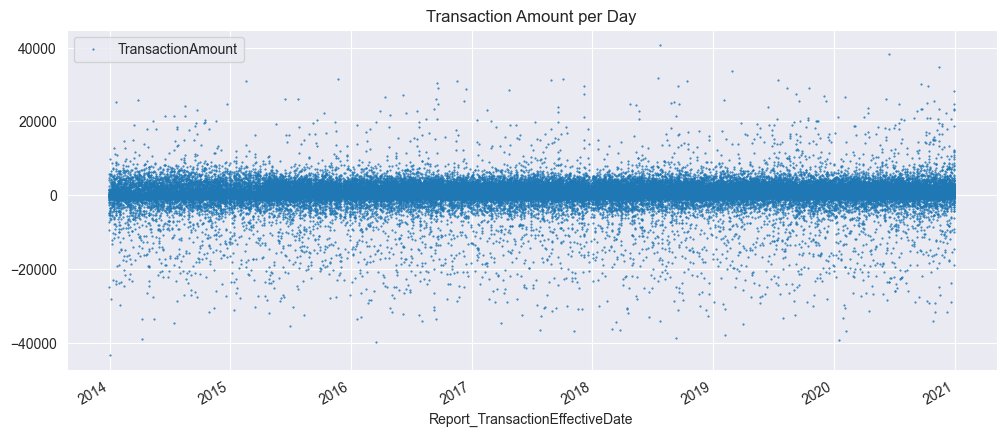

In [78]:
## Plot Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [79]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('B').fillna(0).to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-25,1613.384621
2020-12-28,0.000000
2020-12-29,82156.304473


In [80]:
## Feature engineering to gain a deeper understanding of the data
def create_features(df, label):
    # Create time-based features
    df = df.copy()
    df['date'] = df.index
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayname'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter

    X = df[['year', 'month', 'day', 'dayofweek', 'quarter', "dayname"]]

    if label:
        y = df[label]
        return X, y
    return X


In [81]:
# Add features to df
X, y = create_features(df, "TransactionAmount")
features_and_target = pd.concat([X, y], axis=1)
features_and_target

,year,month,day,dayofweek,quarter,dayname,TransactionAmount
Report_TransactionEffectiveDate,,,,,,,
2013-12-30,2013,12,30,0,4,Monday,-1076.913729
2013-12-31,2013,12,31,1,4,Tuesday,-41733.273687
2014-01-01,2014,1,1,2,1,Wednesday,-3465.890925
2014-01-02,2014,1,2,3,1,Thursday,-45506.653405
2014-01-03,2014,1,3,4,1,Friday,-18386.381900
...,...,...,...,...,...,...,...
2020-12-25,2020,12,25,4,4,Friday,1613.384621
2020-12-28,2020,12,28,0,4,Monday,0.000000
2020-12-29,2020,12,29,1,4,Tuesday,82156.304473


In [82]:
def check_outliers(data):
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(data < lower_bound) | (data > upper_bound)]
    print("Outliers detected:", len(outliers))

    return lower_bound, upper_bound


In [83]:
# Limit outliers
lower_bound, upper_bound = check_outliers(df['TransactionAmount'])
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)
df

Outliers detected: 63


,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-41867.783708
2014-01-03,-18386.381900
...,...
2020-12-25,1613.384621
2020-12-28,0.000000
2020-12-29,73872.407537


In [84]:
# Double Check for extreme
lower_bound, upper_bound = check_outliers(df['TransactionAmount'])

Outliers detected: 0


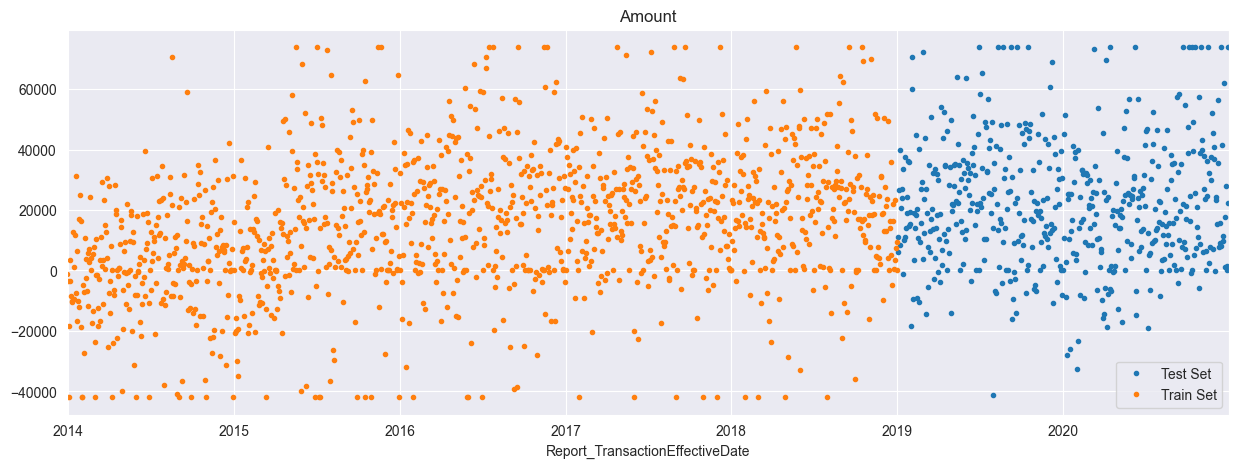

In [85]:
# Split Date for train/test split (80-20)
split_date = '1-Jan-2019'

data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

#Visualize split
data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()


In [86]:
#Shift Transaction Amount and Transform amount using log
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [87]:
# rename columns
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,40791.869979,10.616263
1,2013-12-31,-41733.273687,135.510020,4.916398
2,2014-01-01,-3465.890925,38402.892783,10.555914
3,2014-01-02,-41867.783708,1.000000,0.693147
4,2014-01-03,-18386.381900,23482.401808,10.064049
...,...,...,...,...
1302,2018-12-26,3319.146441,45187.930149,10.718607
1303,2018-12-27,23269.148943,65137.932651,11.084278
1304,2018-12-28,7577.044740,49445.828447,10.808653
1305,2018-12-31,9481.245786,51350.029494,10.846440


In [88]:
# Create model
model = Prophet(
    seasonality_prior_scale=1,
    yearly_seasonality=10,
    weekly_seasonality=5,
    daily_seasonality=False,
    changepoint_prior_scale=0.0007,
    changepoint_range=0.9,
    seasonality_mode='multiplicative',
    interval_width=0.95,
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=1)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=1)

#Fit model
model.fit(data_train_prophet)

19:14:06 - cmdstanpy - INFO - Chain [1] start processing
19:14:07 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
# Use model to predict on test set
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-02,10.708261,6.440879,12.214311,10.708261,10.708261,-0.096624,-0.096624,-0.096624,-0.138175,...,-0.015529,-0.015529,-0.015529,-0.026022,-0.026022,-0.026022,0.0,0.0,0.0,9.228646
1,2019-01-03,10.708340,6.665912,12.719652,10.708340,10.708340,-0.055945,-0.055945,-0.055945,-0.087350,...,-0.006776,-0.006776,-0.006776,-0.024628,-0.024628,-0.024628,0.0,0.0,0.0,9.772969
2,2019-01-04,10.708419,7.098827,13.117615,10.708419,10.708419,-0.011932,-0.011932,-0.011932,-0.048438,...,-0.013563,-0.013563,-0.013563,-0.022943,-0.022943,-0.022943,0.0,0.0,0.0,10.189721
3,2019-01-07,10.708656,7.946530,13.876753,10.708656,10.708656,0.002615,0.002615,0.002615,0.019518,...,0.033679,0.033679,0.033679,-0.016777,-0.016777,-0.016777,0.0,0.0,0.0,10.917663
4,2019-01-08,10.708735,7.463981,13.387399,10.708735,10.708735,-0.005443,-0.005443,-0.005443,-0.015928,...,0.004099,0.004099,0.004099,-0.014585,-0.014585,-0.014585,0.0,0.0,0.0,10.538161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2020-12-25,10.765336,7.597757,13.673457,10.765324,10.765348,0.027595,0.027595,0.027595,-0.009258,...,-0.013563,-0.013563,-0.013563,-0.023290,-0.023290,-0.023290,0.0,0.0,0.0,10.665671
518,2020-12-28,10.765573,8.199850,14.053490,10.765561,10.765585,0.028679,0.028679,0.028679,0.034919,...,0.033679,0.033679,0.033679,-0.027440,-0.027440,-0.027440,0.0,0.0,0.0,11.141497
519,2020-12-29,10.765652,7.773851,13.604985,10.765640,10.765664,0.030884,0.030884,0.030884,0.007086,...,0.004099,0.004099,0.004099,-0.027897,-0.027897,-0.027897,0.0,0.0,0.0,10.841940
520,2020-12-30,10.765730,7.377815,13.323315,10.765719,10.765743,0.009857,0.009857,0.009857,-0.033565,...,-0.015529,-0.015529,-0.015529,-0.027893,-0.027893,-0.027893,0.0,0.0,0.0,10.404374


In [90]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,52386.914757,10.866431
2019-01-03,5997.282482,47298.211866,10.764249
2019-01-04,26741.238955,68042.168338,11.127898
2019-01-07,39674.677746,80975.607130,11.301916
2019-01-08,8270.261060,49571.190443,10.811185
...,...,...,...
2020-12-25,1613.384621,42914.314005,10.666984
2020-12-28,0.000000,41300.929384,10.628664
2020-12-29,73872.407537,115173.336921,11.654202


In [91]:
# Reverse transformed amount to original
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.708261,6.440879,12.214311,10.708261,10.708261,-0.096624,-0.096624,-0.096624,-0.138175,...,-0.015529,-0.015529,-0.026022,-0.026022,-0.026022,0.0,0.0,0.0,9.228646,-31116.187228
1,2019-01-03,10.708340,6.665912,12.719652,10.708340,10.708340,-0.055945,-0.055945,-0.055945,-0.087350,...,-0.006776,-0.006776,-0.024628,-0.024628,-0.024628,0.0,0.0,0.0,9.772969,-23748.121565
2,2019-01-04,10.708419,7.098827,13.117615,10.708419,10.708419,-0.011932,-0.011932,-0.011932,-0.048438,...,-0.013563,-0.013563,-0.022943,-0.022943,-0.022943,0.0,0.0,0.0,10.189721,-14672.854004
3,2019-01-07,10.708656,7.946530,13.876753,10.708656,10.708656,0.002615,0.002615,0.002615,0.019518,...,0.033679,0.033679,-0.016777,-0.016777,-0.016777,0.0,0.0,0.0,10.917663,13840.878508
4,2019-01-08,10.708735,7.463981,13.387399,10.708735,10.708735,-0.005443,-0.005443,-0.005443,-0.015928,...,0.004099,0.004099,-0.014585,-0.014585,-0.014585,0.0,0.0,0.0,10.538161,-3572.804154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2020-12-25,10.765336,7.597757,13.673457,10.765324,10.765348,0.027595,0.027595,0.027595,-0.009258,...,-0.013563,-0.013563,-0.023290,-0.023290,-0.023290,0.0,0.0,0.0,10.665671,1558.060060
518,2020-12-28,10.765573,8.199850,14.053490,10.765561,10.765585,0.028679,0.028679,0.028679,0.034919,...,0.033679,0.033679,-0.027440,-0.027440,-0.027440,0.0,0.0,0.0,11.141497,27673.924833
519,2020-12-29,10.765652,7.773851,13.604985,10.765640,10.765664,0.030884,0.030884,0.030884,0.007086,...,0.004099,0.004099,-0.027897,-0.027897,-0.027897,0.0,0.0,0.0,10.841940,9819.515048
520,2020-12-30,10.765730,7.377815,13.323315,10.765719,10.765743,0.009857,0.009857,0.009857,-0.033565,...,-0.015529,-0.015529,-0.027893,-0.027893,-0.027893,0.0,0.0,0.0,10.404374,-8297.272237


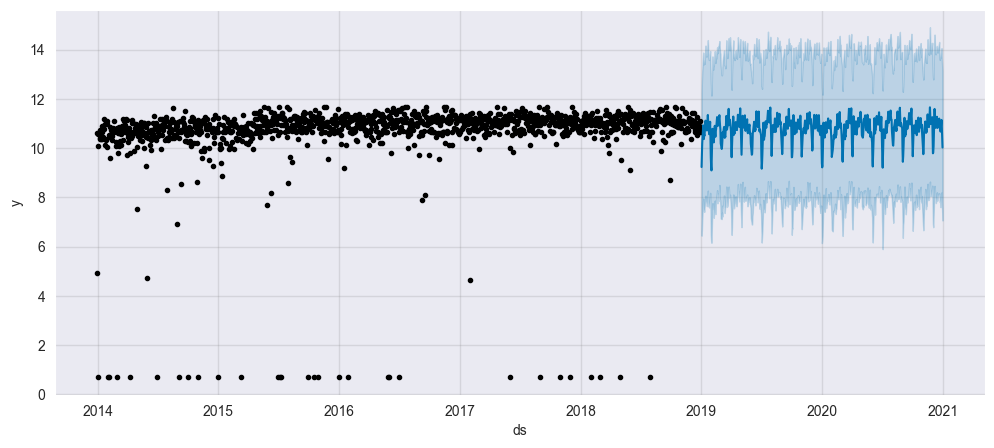

In [92]:
# Plot predicted value
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

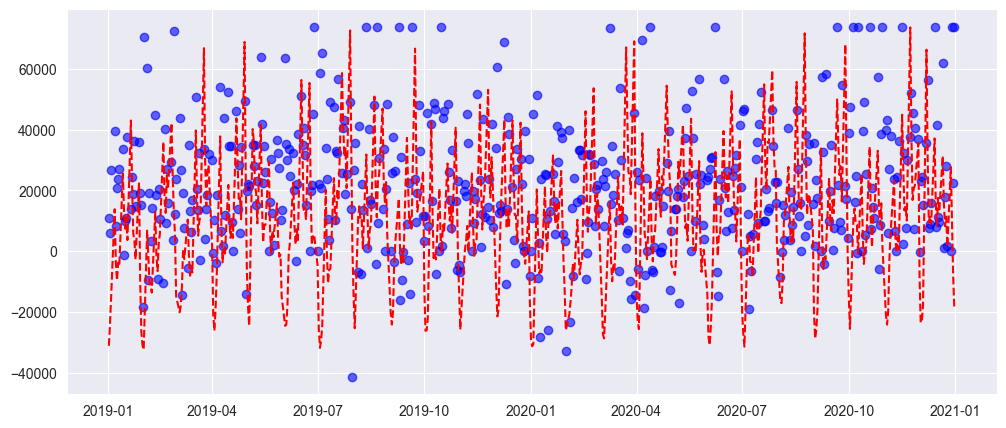

In [93]:
# Plot predicted values with actual values in test set
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [94]:
# RMSE
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))


29805.6202471702

In [95]:
#MAE
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

23417.571086452474

In [96]:
last_date_in_test = data_test.index[-1]

# Calculate the start and end of the next quarter
start_date = last_date_in_test + pd.Timedelta(days=1)  # Start from the next day
end_date = start_date + BQuarterEnd()  # End of the next business quarter

future = pd.date_range(start=start_date, end=end_date, freq='B')
future_df = pd.DataFrame({'ds': future})

forecast_future = model.predict(future_df)
forecast_future



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-01-01,10.765888,6.431625,12.526080,10.765888,10.765888,-0.083325,-0.083325,-0.083325,-0.123480,...,-0.013563,-0.013563,-0.013563,-0.026592,-0.026592,-0.026592,0.0,0.0,0.0,9.436521
1,2021-01-04,10.766125,7.427645,13.191089,10.766125,10.766125,-0.055945,-0.055945,-0.055945,-0.044276,...,0.033679,0.033679,0.033679,-0.022010,-0.022010,-0.022010,0.0,0.0,0.0,10.289442
2,2021-01-05,10.766204,7.555074,13.456128,10.766204,10.766204,-0.011932,-0.011932,-0.011932,-0.027837,...,0.004099,0.004099,0.004099,-0.020004,-0.020004,-0.020004,0.0,0.0,0.0,10.466503
3,2021-01-06,10.766283,7.473764,13.567625,10.766283,10.766283,0.012984,0.012984,0.012984,-0.020416,...,-0.015529,-0.015529,-0.015529,-0.017870,-0.017870,-0.017870,0.0,0.0,0.0,10.546483
4,2021-01-07,10.766362,7.684508,13.643796,10.766362,10.766362,0.013874,0.013874,0.013874,-0.008581,...,-0.006776,-0.006776,-0.006776,-0.015679,-0.015679,-0.015679,0.0,0.0,0.0,10.673977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-03-25,10.772440,8.346809,14.371744,10.772440,10.772441,0.039502,0.039502,0.039502,0.048707,...,-0.006776,-0.006776,-0.006776,0.015981,0.015981,0.015981,0.0,0.0,0.0,11.297136
60,2021-03-26,10.772519,8.384363,14.161047,10.772519,10.772520,0.033401,0.033401,0.033401,0.038109,...,-0.013563,-0.013563,-0.013563,0.018271,0.018271,0.018271,0.0,0.0,0.0,11.183050
61,2021-03-29,10.772756,8.634545,14.813001,10.772756,10.772757,0.023671,0.023671,0.023671,0.080048,...,0.033679,0.033679,0.033679,0.022697,0.022697,0.022697,0.0,0.0,0.0,11.635089
62,2021-03-30,10.772835,8.462926,14.524316,10.772835,10.772836,0.031889,0.031889,0.031889,0.059220,...,0.004099,0.004099,0.004099,0.023232,0.023232,0.023232,0.0,0.0,0.0,11.410802


In [97]:
# Reveresed transformed forecasted values
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2021-01-01,10.765888,6.431625,12.526080,10.765888,10.765888,-0.083325,-0.083325,-0.083325,-0.123480,...,-0.013563,-0.013563,-0.026592,-0.026592,-0.026592,0.0,0.0,0.0,9.436521,-28762.913076
1,2021-01-04,10.766125,7.427645,13.191089,10.766125,10.766125,-0.055945,-0.055945,-0.055945,-0.044276,...,0.033679,0.033679,-0.022010,-0.022010,-0.022010,0.0,0.0,0.0,10.289442,-11880.572687
2,2021-01-05,10.766204,7.555074,13.456128,10.766204,10.766204,-0.011932,-0.011932,-0.011932,-0.027837,...,0.004099,0.004099,-0.020004,-0.020004,-0.020004,0.0,0.0,0.0,10.466503,-6181.744533
3,2021-01-06,10.766283,7.473764,13.567625,10.766283,10.766283,0.012984,0.012984,0.012984,-0.020416,...,-0.015529,-0.015529,-0.017870,-0.017870,-0.017870,0.0,0.0,0.0,10.546483,-3257.519309
4,2021-01-07,10.766362,7.684508,13.643796,10.766362,10.766362,0.013874,0.013874,0.013874,-0.008581,...,-0.006776,-0.006776,-0.015679,-0.015679,-0.015679,0.0,0.0,0.0,10.673977,1915.561628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2021-03-25,10.772440,8.346809,14.371744,10.772440,10.772441,0.039502,0.039502,0.039502,0.048707,...,-0.006776,-0.006776,0.015981,0.015981,0.015981,0.0,0.0,0.0,11.297136,39289.596237
60,2021-03-26,10.772519,8.384363,14.161047,10.772519,10.772520,0.033401,0.033401,0.033401,0.038109,...,-0.013563,-0.013563,0.018271,0.018271,0.018271,0.0,0.0,0.0,11.183050,30600.424534
61,2021-03-29,10.772756,8.634545,14.813001,10.772756,10.772757,0.023671,0.023671,0.023671,0.080048,...,0.033679,0.033679,0.022697,0.022697,0.022697,0.0,0.0,0.0,11.635089,71693.011762
62,2021-03-30,10.772835,8.462926,14.524316,10.772835,10.772836,0.031889,0.031889,0.031889,0.059220,...,0.004099,0.004099,0.023232,0.023232,0.023232,0.0,0.0,0.0,11.410802,48990.879928


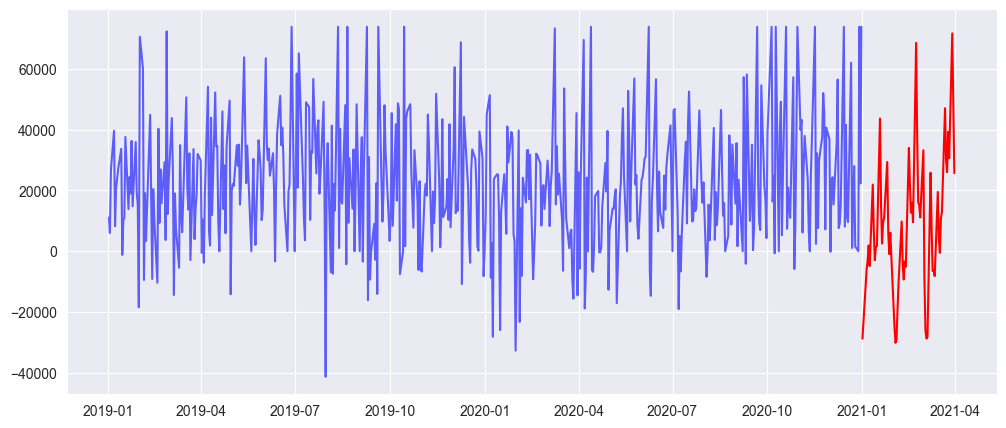

In [98]:
# Plot forecasted values
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(forecast_future['ds'], forecast_future["yhat_original"], color='red', label="Predicted")
plt.show()

In [99]:
# Create date for all days (include weekend)
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
full_df = pd.DataFrame({'Date': full_date_range})


In [100]:
# Prepare DataFrame ready to export
export_df = pd.merge(full_df, forecast_future[['ds', 'yhat_original']], how='left', left_on='Date', right_on='ds')
export_df['yhat_original'] = export_df['yhat_original'].fillna(0)
export_df['yhat_original'] = export_df['yhat_original'].round(2)
export_df['GroupName'] = 'Precision Analyst'
export_df.rename(columns={'Date': 'Date', 'yhat_original': 'TotalPredictedAmount'}, inplace=True)
export_df.drop(columns=['ds'], inplace=True)
export_df = export_df[['GroupName', 'Date', 'TotalPredictedAmount']]
export_df["Date"] = export_df["Date"].dt.date

#Export to excel
export_df.to_excel('forecast_results_prophet_5.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -28762.91
1  Precision Analyst  2021-01-02                  0.00
2  Precision Analyst  2021-01-03                  0.00
3  Precision Analyst  2021-01-04             -11880.57
4  Precision Analyst  2021-01-05              -6181.74
